In [84]:
import pandas as pd
import numpy as np
import cv2
from sklearn.utils import shuffle
from torch.autograd import Variable
from time import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import matplotlib.pyplot as plt

In [2]:
def dataset_load(transforms,batch):
  # Loading Datasets using ImageFolder
  train_dataset = ImageFolder('D:/MSDS/3rd Sem/ML/Assignment/output/train' , transform=transforms) 
  print(len(train_dataset), 'Train Data')
  test_dataset = ImageFolder('D:/MSDS/3rd Sem/ML/Assignment/output/test' , transform=transforms)
  print(len(test_dataset) , "Test Data")
  validation_dataset = ImageFolder('D:/MSDS/3rd Sem/ML/Assignment/output/val' , transform=transforms)
  print(len(validation_dataset) , "validation Data")
  
 

  # Train and Test dataloaders
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch)
  
  
  
  return train_loader,val_loader,test_loader

In [3]:
batch_size=64

transforms = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor(),transforms.Normalize(
                                mean=[0.5, 0.5,0.5],
                                std=[0.5, 0.5,0.5]), transforms.Grayscale()])

train_loader,val_loader,test_loader = dataset_load(transforms,batch_size)

21000 Train Data
6000 Test Data
3000 validation Data


In [66]:
##########################
### MODEL
##########################


class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        # 28x28x1 => 28x28x8
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) # (1(28-1) - 28 + 3) / 2 = 1
        # 28x28x8 => 14x14x8
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(14-1) - 28 + 2) = 0                                       
        # 14x14x8 => 14x14x16
        self.conv_2 = torch.nn.Conv2d(in_channels=16,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) # (1(14-1) - 14 + 3) / 2 = 1                 
        # 14x14x16 => 7x7x16                             
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(7-1) - 14 + 2) = 0

        self.linear_1 = torch.nn.Linear(16*16*16, num_classes)

        
        
    def forward(self, x):
        out = self.conv_1(x)
        out = F.relu(out)
        out = self.pool_1(out)

        out = self.conv_2(out)
        out = F.relu(out)
        out = self.pool_2(out)
        
        logits = self.linear_1(out.view(-1, 16*16*16))
        probas = F.log_softmax(logits, dim=1)
        
        return probas

In [80]:
def train(net, train_loader, val_loader,learning_rate, n_epochs, loss_func, optimizer, device):
    train_loss = []
    train_acc=[]
    val_loss=[]
    val_acc=[]
    # training the model
    for epoch in range(n_epochs):
        tr_loss = 0
        tr_correct = 0
        v_loss=0
        v_correct=0
        # getting the training set
    
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data), Variable(target)
            data, target = data.to(device), target.to(device)
            
            # clearing the Gradients of the model parameters
            optimizer.zero_grad()
            # prediction for training
            net_out = model(data)
            # computing the training and validation loss
            loss_train = loss_func(net_out, target)
            # computing the updated weights of all the model parameters
            loss_train.backward()
            optimizer.step()
            tr_loss += loss_train.item()
            pred = net_out.data.max(1)[1]  # get the index of the max log-probability
            tr_correct += pred.eq(target.data).sum()
            
        train_loss.append(tr_loss/len(train_loader.dataset))
        train_acc.append(tr_correct/len(train_loader.dataset))
    
        print("------------------------------------------------------------------------------------------------")
        print('Epoch: ', epoch)
        print('Training Loss:', tr_loss / len(train_loader.dataset)) 
        print("Training Accuracy:", 100. * tr_correct.item() / len(train_loader.dataset))
        print("------------------------------------------------------------------------------------------------") 
        
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = Variable(data), Variable(target)
            data, target = data.to(device), target.to(device)        
           
            net_out = model(data)
            loss = loss_func(net_out, target)
            v_loss += loss.item()
            pred = net_out.data.max(1)[1]  # get the index of the max log-probability
            v_correct += pred.eq(target.data).sum() 

        val_loss.append(v_loss/len(val_loader.dataset))
        val_acc.append(v_correct/len(val_loader.dataset))
    
        print("------------------------------------------------------------------------------------------------")
        print('Epoch: ', epoch)
        print('Validation Loss:', v_loss / len(val_loader.dataset)) 
        print("Validation Accuracy:", 100. *  v_correct.item() / len(val_loader.dataset) )
        print("------------------------------------------------------------------------------------------------") 

    return net, train_loss, train_acc, val_loss, val_acc

In [72]:
def save_network(path , model):
  torch.save(model.state_dict(), path)

In [73]:
def load_network(path, model):
  model.load_state_dict(torch.load(path))

In [110]:
def train_vitualization(train_loss,train_accuracy,val_loss,val_accuracy):

  plt.figure(figsize=(3,3))
  plt.title("Plot the resulting loss over epoch") 
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend()
  plt.show()

  plt.figure(figsize=(3,3))
  plt.title("Plot the Resulting Acuracy over epoch")
  plt.plot(train_accuracy, label='Training Accuracy')
  plt.plot(val_accuracy, label='Validation Accuracy')
  plt.legend()
  plt.show()

In [81]:
lr=0.005
n_epoch=25
# defining the model
model = ConvNet(num_classes=2)
model = model.to(device)
# defining the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
# defining the loss function
loss_func = nn.NLLLoss()
#loss_func = CrossEntropyLoss()

# this statement tell our code if there gpu available on our machine or not.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print(model)

model, train_loss, train_accuracy, val_loss, val_accuracy  = train(model, train_loader, val_loader,lr, n_epoch ,loss_func, optimizer, device)
save_network("Model.pt", model)


ConvNet(
  (conv_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=4096, out_features=2, bias=True)
)
------------------------------------------------------------------------------------------------
Epoch:  0
Training Loss: 0.00430146203402962
Training Accuracy: 88.64761904761905
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
Epoch:  0
Validation Loss: 0.0007968492545187473
Validation Accuracy: 98.66666666666667
------------------------------------------------------------------------------------------------
----------------

NameError: name 'plt' is not defined

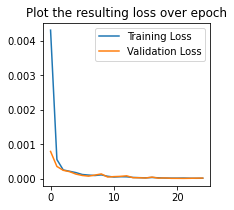

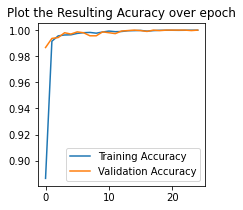

In [111]:
train_vitualization(train_loss, train_accuracy, val_loss, val_accuracy)

In [106]:
def test(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    class_correct=[0]*10
    class_total=[0]*10
    test_accuracy=[]
    test_loss=[]
    t_loss =0
    correct=0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = Variable(data), Variable(target)
            data, target = data.to(device), target.to(device)
            net_out = model(data)
            loss = loss_func(net_out, target)
            
            pred=net_out.data.max(1)[1]
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if device == "cpu" else np.squeeze(correct_tensor.cpu().numpy())
                 
            for i in range(target.size(0)):
                
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
                #Statistics
            prediction = net_out.argmax(dim=1)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
        
        for i in range(2):
              t_loss += loss.item()
              test_loss.append(t_loss / len(test_loader.dataset))
              test_accuracy.append(100 * class_correct[i] / class_total[i])

        
        print('Test Loss:', t_loss / len(test_loader.dataset))
        print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))
        
    
    return [i.item() for i in actuals], [i.item() for i in predictions], test_accuracy, test_loss
    
    

In [107]:
def conf(actuals, predictions):
  print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
  print('Accuracy score: %f' % accuracy_score(actuals, predictions))

  print('------------------------Confusion matrix----------------------------------')
  import seaborn as sns
  plt.figure(figsize=(10,9))
  ax = sns.heatmap(confusion_matrix(actuals, predictions), annot=True, vmax=30)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('True')
  plt.show()

In [108]:
def test_vitualization(actuals,predictions,test_accuracy,test_loss):
    conf(actuals,predictions)

Test Loss: 6.669738795608282e-07

Test Accuracy (Overall): 99% (5998/6000)
F1 score: 0.999667
Accuracy score: 0.999667
------------------------Confusion matrix----------------------------------


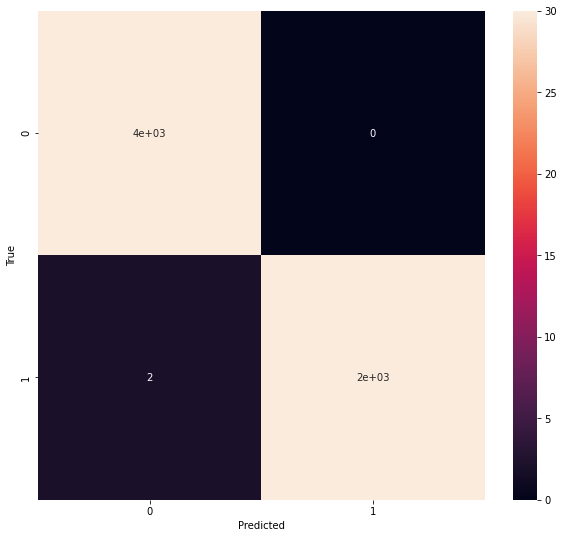

In [109]:
load_network("Model.pt",model)
actuals, predictions, test_accuracy,test_loss = test(model, device, test_loader)
test_vitualization(actuals,predictions,test_accuracy,test_loss) 